In [1]:
from IPython.core.interactiveshell import InteractiveShell
import os
import sys
import time
from functools import partial
import pickle
import multiprocessing
import pixiedust as pxdb
import PIL
from matplotlib import pyplot as plt
import seaborn as sns
from collections import OrderedDict as ODict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# PYTORCH
import torch as tc
import torchvision as tcvis
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torch.nn import functional as fu
# TORCH HELPERS
import hiddenlayer as hl
from torchsummary import summary

InteractiveShell.ast_node_interactivity = 'all'

# %pixie_debugger
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sns.set(style='white', context='notebook', palette='tab10')
%config IPCompleter.greedy = True
%config IPCompleter.use_jedi = True


basepath = '/home/alk/Documents/Git/Kaggles/MNIST'
try:
    os.chdir(basepath)
    print(os.getcwd())
except NotADirectoryError:
    pass

Pixiedust database opened successfully


/home/alk/Documents/Git/Kaggles/MNIST


In [2]:
# run only when needed

datadir = os.getcwd() + '/data'
filenames = ['train.csv', 'test.csv']
datadict = ODict()
for files in filenames:
    try:
        with open(datadir + '/' + files, mode='r') as csvfile:
            datadict[files] = np.loadtxt(csvfile, delimiter=",", skiprows=1)
            csvfile.close()
        print('found file: {}'.format(files))
    except FileNotFoundError:
        print('skipping file ./{}'.format(files))

print(datadict.keys(), filenames)

found file: train.csv
found file: test.csv
odict_keys(['train.csv', 'test.csv']) ['train.csv', 'test.csv']


In [3]:
traindata = datadict[filenames[0]]
testdata = datadict[filenames[-1]]

trainlabels = traindata[:, 0].reshape(-1, 1)
traindata = traindata[:, 1:].reshape(-1, 28, 28)
testdata = testdata.reshape(-1, 28, 28)
print(traindata.shape, trainlabels.shape, testdata.shape)

(42000, 28, 28) (42000, 1) (28000, 28, 28)


In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(traindata, trainlabels, 
                                                      test_size=0.2)

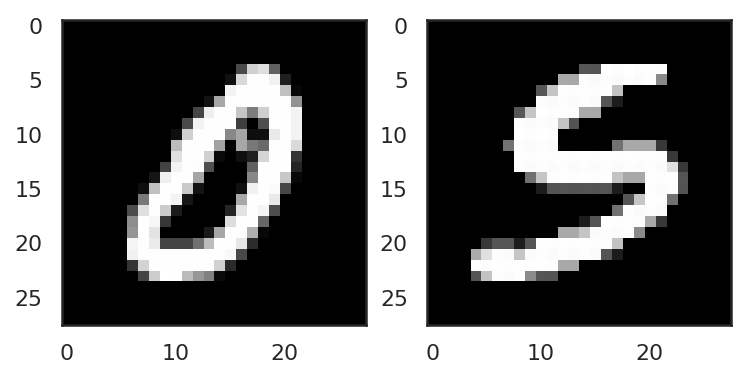

In [5]:
fig, ax = plt.subplots(1, 2, sharex=True, squeeze=True)
ax[0].imshow(x_train[-1, :, :], cmap='gray')
ax[1].imshow(x_valid[0, :, :], cmap='gray')

target: tensor([6])


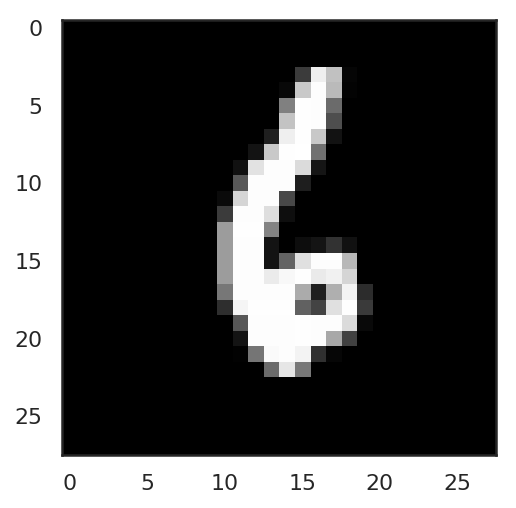

In [6]:
class NpDataset(Dataset):

    def __init__(self, x=x_train, y=y_train,
                 transforms=None):
        super().__init__()

        self.x = x
        self.y = y
        self.transform = transforms
        
    def __len__(self):

        return self.x.shape[0]

    def __getitem__(self, index):

        if self.y is not None:
            image, label = self.x[index], self.y[index]
            label = tc.from_numpy(label).type(tc.LongTensor)
        else:
            image, label = self.x[index], None
        
        # HxWxC, UINT8
        image = image.astype(np.uint8).reshape(28, 28, 1)
        # image = tc.from_numpy(image).type(tc.FloatTensor)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# test
test_set = NpDataset()
print(f'target: {test_set.__getitem__(0)[1]}')
plt.imshow(test_set.__getitem__(0)[0].reshape(28, 28), cmap='gray')

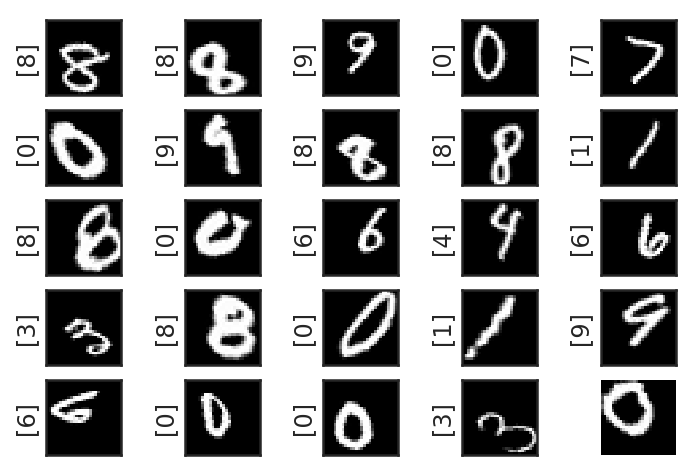

In [7]:
MNIST_train_transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.RandomAffine(30, (0.15,0.15),
                                                                    (0.75,1.25), 30,
                                                                    PIL.Image.BICUBIC,0),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,),
                                                                 (0.3081,))])

MNIST_test_transform = transforms.Compose([transforms.ToTensor(),
                                           transforms.Normalize((0.1307,),
                                                                (0.3081,))])

# test
test_set = NpDataset(transforms=MNIST_train_transform)

fig, axes = plt.subplots(5, 5, sharex=True, sharey=True)
_plots = None

for axs in axes:
    for ax in axs:
        data = test_set.__getitem__(np.random.randint(0, x_train.shape[0]))
        _plots = ax.imshow(data[0].reshape(28, 28), cmap='gray');
        _plots = ax.set_ylabel(str(data[1].numpy()))
        
_plots = plt.yticks([], [])
_plots = plt.xticks([], [])
_plots = plt.axis('off')
plt.show()

In [8]:
def my_collate(batch):
    
    data = tc.stack([item[0] for item in batch])
    target = tc.stack([item[1] for item in batch])
    
    return [data, target.view(-1)]

NN_trainloader = DataLoader(NpDataset(transforms=MNIST_train_transform),
                            batch_size=210,
                            shuffle=True,
                            collate_fn=my_collate,
                            num_workers=8,
                            pin_memory=True)

NN_valloader = DataLoader(NpDataset(x=x_valid, y=y_valid,
                                     transforms=MNIST_test_transform),
                           batch_size=210,
                           shuffle=True,
                           collate_fn=my_collate,
                           num_workers=8,
                           pin_memory=True)

NN_testloader = DataLoader(NpDataset(x=testdata, y=None,
                                     transforms=MNIST_test_transform),
                           batch_size=210,
                           shuffle=True,
                           collate_fn=my_collate,
                           num_workers=8,
                           pin_memory=True)

# test
img, lbl = next(iter(NN_trainloader))
print(img.shape, lbl.shape)

torch.Size([210, 1, 28, 28]) torch.Size([210])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 24, 24]             650
            Conv2d-2             [-1, 50, 8, 8]          31,300
            Linear-3                  [-1, 400]         320,400
            Conv2d-4           [-1, 50, 22, 22]           2,500
            Conv2d-5          [-1, 100, 16, 16]         245,100
            Linear-6                  [-1, 400]         640,400
            Linear-7                  [-1, 100]          80,100
            Linear-8                   [-1, 10]           1,010
Total params: 1,321,460
Trainable params: 1,321,460
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 5.04
Estimated Total Size (MB): 5.57
----------------------------------------------------------------
None


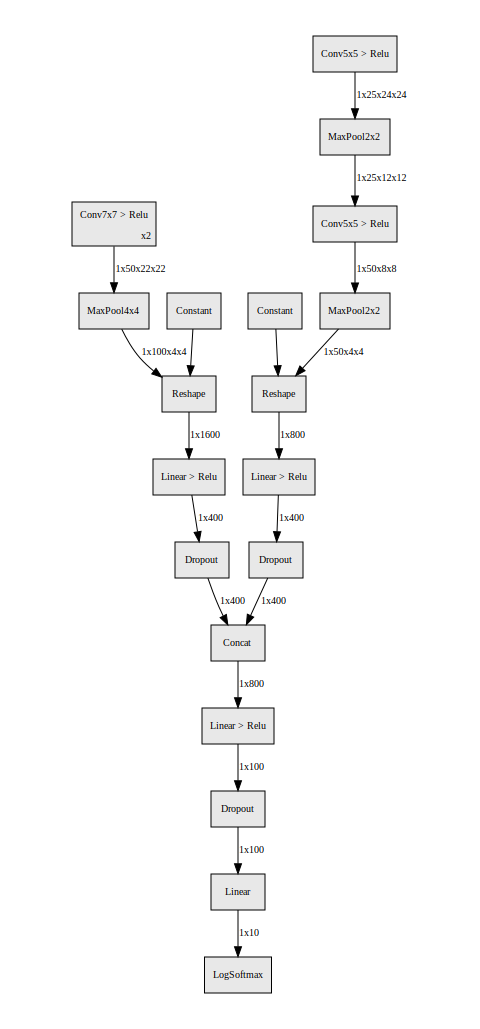

In [9]:
class MNIST_CNN(nn.Module):
    
    def __init__(self,
                 dropout_fcp=0.0):
        super(MNIST_CNN, self).__init__()
        
        self.dropout_p = dropout_fcp
        
        self.conv1 = nn.Conv2d(1, 25, 5, 1) #24
        self.conv2 = nn.Conv2d(25, 50, 5, 1) #20
        
        self.conv3 = nn.Conv2d(1, 50, 7, 1)
        self.conv4 = nn.Conv2d(50, 100, 7, 1)
        
        self.fc1a = nn.Linear(4*4*50, 400)
        self.fc1b = nn.Linear(4*4*100, 400)
        
        self.fcf1 = nn.Linear(800,100)
        self.fcf2 = nn.Linear(100,10)
        
    def forward(self, x):
        
        x1 = fu.relu(self.conv1(x))
        x1 = fu.max_pool2d(x1, 2, 2)
        x1 = fu.relu(self.conv2(x1))
        x1 = fu.max_pool2d(x1, 2, 2)
        x1 = x1.view(-1, 4*4*50)
        x1 = fu.relu(self.fc1a(x1))
        x1 = fu.dropout(x1, p=self.dropout_p, 
                        training=self.training)
        
        x2 = fu.relu(self.conv3(x))
        x2 = fu.relu(self.conv4(x2))
        x2 = fu.max_pool2d(x2, 4, 4)
        x2 = x2.view(-1, 4*4*100)
        x2 = fu.relu(self.fc1b(x2))
        x2 = fu.dropout(x2, p=self.dropout_p, 
                        training=self.training)
        
        x = tc.cat((x1, x2), dim=1)
        
        x = fu.relu(self.fcf1(x))
        x = fu.dropout(x, p=self.dropout_p,
                       training=self.training)
        
        x = self.fcf2(x)
        x = fu.log_softmax(x, dim=1)
        
        return x
        
# test

test_cnn = MNIST_CNN().cuda()
print(summary(test_cnn.cuda(), (1,28,28), device='cuda'))
hl.build_graph(model=test_cnn.cuda(), args=tc.randn(1,1,28,28).cuda())

In [15]:
from inferno.trainers.basic import Trainer

SAVE_DIRECTORY = './saves'
LOG_DIRECTORY = './logs'
DEVICE = 'cuda'

ModelMNIST = MNIST_CNN(dropout_fcp=0.25).cuda()

trainer = Trainer(ModelMNIST) \
    .build_criterion('NLLLoss') \
    .build_metric('CategoricalError') \
    .build_optimizer(optim.Adam, weight_decay=0.0001, lr=0.0001) \
    .validate_every((2, 'epochs')) \
    .save_every((5, 'epochs')) \
    .save_to_directory(SAVE_DIRECTORY) \
    .set_max_num_epochs(10)

trainer \
    .bind_loader('train', NN_trainloader) \
    .bind_loader('validate', NN_valloader)

trainer.cuda()
trainer.fit()



[+][2019-01-04 01:30:30.062346] [PROGRESS] Training iteration 0 (batch 0 of epoch 0).
[+][2019-01-04 01:30:30.415129] [PROGRESS] Training iteration 1 (batch 1 of epoch 0).
[+][2019-01-04 01:30:30.439858] [PROGRESS] Training iteration 2 (batch 2 of epoch 0).
[+][2019-01-04 01:30:30.463178] [PROGRESS] Training iteration 3 (batch 3 of epoch 0).
[+][2019-01-04 01:30:30.485294] [PROGRESS] Training iteration 4 (batch 4 of epoch 0).
[+][2019-01-04 01:30:30.507664] [PROGRESS] Training iteration 5 (batch 5 of epoch 0).
[+][2019-01-04 01:30:30.529149] [PROGRESS] Training iteration 6 (batch 6 of epoch 0).
[+][2019-01-04 01:30:30.549820] [PROGRESS] Training iteration 7 (batch 7 of epoch 0).
[+][2019-01-04 01:30:30.570494] [PROGRESS] Training iteration 8 (batch 8 of epoch 0).
[+][2019-01-04 01:30:30.590513] [PROGRESS] Training iteration 9 (batch 9 of epoch 0).
[+][2019-01-04 01:30:30.610129] [PROGRESS] Training iteration 10 (batch 10 of epoch 0).
[+][2019-01-04 01:30:30.629541] [PROGRESS] Training 

[+][2019-01-04 01:30:32.343577] [PROGRESS] Training iteration 95 (batch 95 of epoch 0).
[+][2019-01-04 01:30:32.362502] [PROGRESS] Training iteration 96 (batch 96 of epoch 0).
[+][2019-01-04 01:30:32.382567] [PROGRESS] Training iteration 97 (batch 97 of epoch 0).
[+][2019-01-04 01:30:32.403019] [PROGRESS] Training iteration 98 (batch 98 of epoch 0).
[+][2019-01-04 01:30:32.422175] [PROGRESS] Training iteration 99 (batch 99 of epoch 0).
[+][2019-01-04 01:30:32.440528] [PROGRESS] Training iteration 100 (batch 100 of epoch 0).
[+][2019-01-04 01:30:32.458980] [PROGRESS] Training iteration 101 (batch 101 of epoch 0).
[+][2019-01-04 01:30:32.477399] [PROGRESS] Training iteration 102 (batch 102 of epoch 0).
[+][2019-01-04 01:30:32.495925] [PROGRESS] Training iteration 103 (batch 103 of epoch 0).
[+][2019-01-04 01:30:32.514648] [PROGRESS] Training iteration 104 (batch 104 of epoch 0).
[+][2019-01-04 01:30:32.535549] [PROGRESS] Training iteration 105 (batch 105 of epoch 0).
[+][2019-01-04 01:30

[+][2019-01-04 01:30:34.627485] [PROGRESS] Training iteration 193 (batch 33 of epoch 1).
[+][2019-01-04 01:30:34.646327] [PROGRESS] Training iteration 194 (batch 34 of epoch 1).
[+][2019-01-04 01:30:34.666022] [PROGRESS] Training iteration 195 (batch 35 of epoch 1).
[+][2019-01-04 01:30:34.685679] [PROGRESS] Training iteration 196 (batch 36 of epoch 1).
[+][2019-01-04 01:30:34.704868] [PROGRESS] Training iteration 197 (batch 37 of epoch 1).
[+][2019-01-04 01:30:34.724381] [PROGRESS] Training iteration 198 (batch 38 of epoch 1).
[+][2019-01-04 01:30:34.742884] [PROGRESS] Training iteration 199 (batch 39 of epoch 1).
[+][2019-01-04 01:30:34.762556] [PROGRESS] Training iteration 200 (batch 40 of epoch 1).
[+][2019-01-04 01:30:34.782408] [PROGRESS] Training iteration 201 (batch 41 of epoch 1).
[+][2019-01-04 01:30:34.802251] [PROGRESS] Training iteration 202 (batch 42 of epoch 1).
[+][2019-01-04 01:30:34.820340] [PROGRESS] Training iteration 203 (batch 43 of epoch 1).
[+][2019-01-04 01:30:

[+][2019-01-04 01:30:36.546993] [PROGRESS] Training iteration 290 (batch 130 of epoch 1).
[+][2019-01-04 01:30:36.567119] [PROGRESS] Training iteration 291 (batch 131 of epoch 1).
[+][2019-01-04 01:30:36.589677] [PROGRESS] Training iteration 292 (batch 132 of epoch 1).
[+][2019-01-04 01:30:36.610015] [PROGRESS] Training iteration 293 (batch 133 of epoch 1).
[+][2019-01-04 01:30:36.631136] [PROGRESS] Training iteration 294 (batch 134 of epoch 1).
[+][2019-01-04 01:30:36.653767] [PROGRESS] Training iteration 295 (batch 135 of epoch 1).
[+][2019-01-04 01:30:36.674290] [PROGRESS] Training iteration 296 (batch 136 of epoch 1).
[+][2019-01-04 01:30:36.694966] [PROGRESS] Training iteration 297 (batch 137 of epoch 1).
[+][2019-01-04 01:30:36.714062] [PROGRESS] Training iteration 298 (batch 138 of epoch 1).
[+][2019-01-04 01:30:36.732886] [PROGRESS] Training iteration 299 (batch 139 of epoch 1).
[+][2019-01-04 01:30:36.751291] [PROGRESS] Training iteration 300 (batch 140 of epoch 1).
[+][2019-0

[+][2019-01-04 01:30:39.001396] [PROGRESS] Training iteration 29 (batch 30 of epoch 2).
[+][2019-01-04 01:30:39.021589] [PROGRESS] Training iteration 30 (batch 31 of epoch 2).
[+][2019-01-04 01:30:39.040830] [PROGRESS] Training iteration 31 (batch 32 of epoch 2).
[+][2019-01-04 01:30:39.059515] [PROGRESS] Training iteration 32 (batch 33 of epoch 2).
[+][2019-01-04 01:30:39.079219] [PROGRESS] Training iteration 33 (batch 34 of epoch 2).
[+][2019-01-04 01:30:39.097700] [PROGRESS] Training iteration 34 (batch 35 of epoch 2).
[+][2019-01-04 01:30:39.116216] [PROGRESS] Training iteration 35 (batch 36 of epoch 2).
[+][2019-01-04 01:30:39.137100] [PROGRESS] Training iteration 36 (batch 37 of epoch 2).
[+][2019-01-04 01:30:39.158392] [PROGRESS] Training iteration 37 (batch 38 of epoch 2).
[+][2019-01-04 01:30:39.178831] [PROGRESS] Training iteration 38 (batch 39 of epoch 2).
[+][2019-01-04 01:30:39.198515] [PROGRESS] Training iteration 39 (batch 40 of epoch 2).
[+][2019-01-04 01:30:39.218228] 

[+][2019-01-04 01:30:40.929860] [PROGRESS] Training iteration 128 (batch 129 of epoch 2).
[+][2019-01-04 01:30:40.951161] [PROGRESS] Training iteration 129 (batch 130 of epoch 2).
[+][2019-01-04 01:30:40.971228] [PROGRESS] Training iteration 130 (batch 131 of epoch 2).
[+][2019-01-04 01:30:40.991149] [PROGRESS] Training iteration 131 (batch 132 of epoch 2).
[+][2019-01-04 01:30:41.010567] [PROGRESS] Training iteration 132 (batch 133 of epoch 2).
[+][2019-01-04 01:30:41.029106] [PROGRESS] Training iteration 133 (batch 134 of epoch 2).
[+][2019-01-04 01:30:41.047276] [PROGRESS] Training iteration 134 (batch 135 of epoch 2).
[+][2019-01-04 01:30:41.067268] [PROGRESS] Training iteration 135 (batch 136 of epoch 2).
[+][2019-01-04 01:30:41.087176] [PROGRESS] Training iteration 136 (batch 137 of epoch 2).
[+][2019-01-04 01:30:41.106721] [PROGRESS] Training iteration 137 (batch 138 of epoch 2).
[+][2019-01-04 01:30:41.125151] [PROGRESS] Training iteration 138 (batch 139 of epoch 2).
[+][2019-0

[+][2019-01-04 01:30:43.206545] [PROGRESS] Training iteration 225 (batch 66 of epoch 3).
[+][2019-01-04 01:30:43.225260] [PROGRESS] Training iteration 226 (batch 67 of epoch 3).
[+][2019-01-04 01:30:43.245573] [PROGRESS] Training iteration 227 (batch 68 of epoch 3).
[+][2019-01-04 01:30:43.265403] [PROGRESS] Training iteration 228 (batch 69 of epoch 3).
[+][2019-01-04 01:30:43.284902] [PROGRESS] Training iteration 229 (batch 70 of epoch 3).
[+][2019-01-04 01:30:43.303566] [PROGRESS] Training iteration 230 (batch 71 of epoch 3).
[+][2019-01-04 01:30:43.322188] [PROGRESS] Training iteration 231 (batch 72 of epoch 3).
[+][2019-01-04 01:30:43.341130] [PROGRESS] Training iteration 232 (batch 73 of epoch 3).
[+][2019-01-04 01:30:43.361221] [PROGRESS] Training iteration 233 (batch 74 of epoch 3).
[+][2019-01-04 01:30:43.381050] [PROGRESS] Training iteration 234 (batch 75 of epoch 3).
[+][2019-01-04 01:30:43.400147] [PROGRESS] Training iteration 235 (batch 76 of epoch 3).
[+][2019-01-04 01:30:

[+][2019-01-04 01:30:45.429123] [INFO    ] Breaking to validate.
[+][2019-01-04 01:30:45.429348] [INFO    ] Validating.
[+][2019-01-04 01:30:45.718997] [PROGRESS] Validating iteration 0.
[+][2019-01-04 01:30:45.729159] [PROGRESS] Validating iteration 1.
[+][2019-01-04 01:30:45.736031] [PROGRESS] Validating iteration 2.
[+][2019-01-04 01:30:45.742320] [PROGRESS] Validating iteration 3.
[+][2019-01-04 01:30:45.748165] [PROGRESS] Validating iteration 4.
[+][2019-01-04 01:30:45.753933] [PROGRESS] Validating iteration 5.
[+][2019-01-04 01:30:45.759925] [PROGRESS] Validating iteration 6.
[+][2019-01-04 01:30:45.766246] [PROGRESS] Validating iteration 7.
[+][2019-01-04 01:30:45.772690] [PROGRESS] Validating iteration 8.
[+][2019-01-04 01:30:45.778774] [PROGRESS] Validating iteration 9.
[+][2019-01-04 01:30:45.785096] [PROGRESS] Validating iteration 10.
[+][2019-01-04 01:30:45.791198] [PROGRESS] Validating iteration 11.
[+][2019-01-04 01:30:45.797158] [PROGRESS] Validating iteration 12.
[+][20

[+][2019-01-04 01:30:47.196631] [PROGRESS] Training iteration 61 (batch 62 of epoch 4).
[+][2019-01-04 01:30:47.217599] [PROGRESS] Training iteration 62 (batch 63 of epoch 4).
[+][2019-01-04 01:30:47.237021] [PROGRESS] Training iteration 63 (batch 64 of epoch 4).
[+][2019-01-04 01:30:47.255418] [PROGRESS] Training iteration 64 (batch 65 of epoch 4).
[+][2019-01-04 01:30:47.274994] [PROGRESS] Training iteration 65 (batch 66 of epoch 4).
[+][2019-01-04 01:30:47.294745] [PROGRESS] Training iteration 66 (batch 67 of epoch 4).
[+][2019-01-04 01:30:47.314160] [PROGRESS] Training iteration 67 (batch 68 of epoch 4).
[+][2019-01-04 01:30:47.333729] [PROGRESS] Training iteration 68 (batch 69 of epoch 4).
[+][2019-01-04 01:30:47.353518] [PROGRESS] Training iteration 69 (batch 70 of epoch 4).
[+][2019-01-04 01:30:47.373423] [PROGRESS] Training iteration 70 (batch 71 of epoch 4).
[+][2019-01-04 01:30:47.392666] [PROGRESS] Training iteration 71 (batch 72 of epoch 4).
[+][2019-01-04 01:30:47.412224] 

[+][2019-01-04 01:30:49.112192] [PROGRESS] Training iteration 159 (batch 160 of epoch 4).
[+][2019-01-04 01:30:49.531256] [INFO    ] Breaking to save.
[+][2019-01-04 01:30:49.532143] [INFO    ] Saving.
[+][2019-01-04 01:30:49.626814] [INFO    ] Saved to ./saves.
[+][2019-01-04 01:30:49.627016] [PROGRESS] Training iteration 0 (batch 1 of epoch 5).
[+][2019-01-04 01:30:49.645524] [PROGRESS] Training iteration 1 (batch 2 of epoch 5).
[+][2019-01-04 01:30:49.664400] [PROGRESS] Training iteration 2 (batch 3 of epoch 5).
[+][2019-01-04 01:30:49.684413] [PROGRESS] Training iteration 3 (batch 4 of epoch 5).
[+][2019-01-04 01:30:49.702712] [PROGRESS] Training iteration 4 (batch 5 of epoch 5).
[+][2019-01-04 01:30:49.720961] [PROGRESS] Training iteration 5 (batch 6 of epoch 5).


/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MNIST_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


[+][2019-01-04 01:30:49.739615] [PROGRESS] Training iteration 6 (batch 7 of epoch 5).
[+][2019-01-04 01:30:49.759088] [PROGRESS] Training iteration 7 (batch 8 of epoch 5).
[+][2019-01-04 01:30:49.779173] [PROGRESS] Training iteration 8 (batch 9 of epoch 5).
[+][2019-01-04 01:30:49.798995] [PROGRESS] Training iteration 9 (batch 10 of epoch 5).
[+][2019-01-04 01:30:49.817246] [PROGRESS] Training iteration 10 (batch 11 of epoch 5).
[+][2019-01-04 01:30:49.836578] [PROGRESS] Training iteration 11 (batch 12 of epoch 5).
[+][2019-01-04 01:30:49.856548] [PROGRESS] Training iteration 12 (batch 13 of epoch 5).
[+][2019-01-04 01:30:49.876499] [PROGRESS] Training iteration 13 (batch 14 of epoch 5).
[+][2019-01-04 01:30:49.896984] [PROGRESS] Training iteration 14 (batch 15 of epoch 5).
[+][2019-01-04 01:30:49.915391] [PROGRESS] Training iteration 15 (batch 16 of epoch 5).
[+][2019-01-04 01:30:49.934726] [PROGRESS] Training iteration 16 (batch 17 of epoch 5).
[+][2019-01-04 01:30:49.954508] [PROGRE

[+][2019-01-04 01:30:51.670587] [PROGRESS] Training iteration 105 (batch 106 of epoch 5).
[+][2019-01-04 01:30:51.690842] [PROGRESS] Training iteration 106 (batch 107 of epoch 5).
[+][2019-01-04 01:30:51.711762] [PROGRESS] Training iteration 107 (batch 108 of epoch 5).
[+][2019-01-04 01:30:51.731524] [PROGRESS] Training iteration 108 (batch 109 of epoch 5).
[+][2019-01-04 01:30:51.751575] [PROGRESS] Training iteration 109 (batch 110 of epoch 5).
[+][2019-01-04 01:30:51.770557] [PROGRESS] Training iteration 110 (batch 111 of epoch 5).
[+][2019-01-04 01:30:51.792390] [PROGRESS] Training iteration 111 (batch 112 of epoch 5).
[+][2019-01-04 01:30:51.811551] [PROGRESS] Training iteration 112 (batch 113 of epoch 5).
[+][2019-01-04 01:30:51.829609] [PROGRESS] Training iteration 113 (batch 114 of epoch 5).
[+][2019-01-04 01:30:51.849574] [PROGRESS] Training iteration 114 (batch 115 of epoch 5).
[+][2019-01-04 01:30:51.868242] [PROGRESS] Training iteration 115 (batch 116 of epoch 5).
[+][2019-0

[+][2019-01-04 01:30:53.816292] [PROGRESS] Training iteration 4 (batch 5 of epoch 6).
[+][2019-01-04 01:30:53.836564] [PROGRESS] Training iteration 5 (batch 6 of epoch 6).
[+][2019-01-04 01:30:53.856243] [PROGRESS] Training iteration 6 (batch 7 of epoch 6).
[+][2019-01-04 01:30:53.875648] [PROGRESS] Training iteration 7 (batch 8 of epoch 6).
[+][2019-01-04 01:30:53.895193] [PROGRESS] Training iteration 8 (batch 9 of epoch 6).
[+][2019-01-04 01:30:53.913801] [PROGRESS] Training iteration 9 (batch 10 of epoch 6).
[+][2019-01-04 01:30:53.932251] [PROGRESS] Training iteration 10 (batch 11 of epoch 6).
[+][2019-01-04 01:30:53.950723] [PROGRESS] Training iteration 11 (batch 12 of epoch 6).
[+][2019-01-04 01:30:53.969443] [PROGRESS] Training iteration 12 (batch 13 of epoch 6).
[+][2019-01-04 01:30:53.988472] [PROGRESS] Training iteration 13 (batch 14 of epoch 6).
[+][2019-01-04 01:30:54.008596] [PROGRESS] Training iteration 14 (batch 15 of epoch 6).
[+][2019-01-04 01:30:54.030439] [PROGRESS] 

[+][2019-01-04 01:30:55.735976] [PROGRESS] Training iteration 102 (batch 103 of epoch 6).
[+][2019-01-04 01:30:55.756089] [PROGRESS] Training iteration 103 (batch 104 of epoch 6).
[+][2019-01-04 01:30:55.775003] [PROGRESS] Training iteration 104 (batch 105 of epoch 6).
[+][2019-01-04 01:30:55.794603] [PROGRESS] Training iteration 105 (batch 106 of epoch 6).
[+][2019-01-04 01:30:55.813352] [PROGRESS] Training iteration 106 (batch 107 of epoch 6).
[+][2019-01-04 01:30:55.833175] [PROGRESS] Training iteration 107 (batch 108 of epoch 6).
[+][2019-01-04 01:30:55.852824] [PROGRESS] Training iteration 108 (batch 109 of epoch 6).
[+][2019-01-04 01:30:55.873397] [PROGRESS] Training iteration 109 (batch 110 of epoch 6).
[+][2019-01-04 01:30:55.893411] [PROGRESS] Training iteration 110 (batch 111 of epoch 6).
[+][2019-01-04 01:30:55.912417] [PROGRESS] Training iteration 111 (batch 112 of epoch 6).
[+][2019-01-04 01:30:55.933647] [PROGRESS] Training iteration 112 (batch 113 of epoch 6).
[+][2019-0

[+][2019-01-04 01:30:58.140068] [PROGRESS] Training iteration 202 (batch 43 of epoch 7).
[+][2019-01-04 01:30:58.161268] [PROGRESS] Training iteration 203 (batch 44 of epoch 7).
[+][2019-01-04 01:30:58.181934] [PROGRESS] Training iteration 204 (batch 45 of epoch 7).
[+][2019-01-04 01:30:58.202113] [PROGRESS] Training iteration 205 (batch 46 of epoch 7).
[+][2019-01-04 01:30:58.223061] [PROGRESS] Training iteration 206 (batch 47 of epoch 7).
[+][2019-01-04 01:30:58.245331] [PROGRESS] Training iteration 207 (batch 48 of epoch 7).
[+][2019-01-04 01:30:58.267288] [PROGRESS] Training iteration 208 (batch 49 of epoch 7).
[+][2019-01-04 01:30:58.288213] [PROGRESS] Training iteration 209 (batch 50 of epoch 7).
[+][2019-01-04 01:30:58.308140] [PROGRESS] Training iteration 210 (batch 51 of epoch 7).
[+][2019-01-04 01:30:58.328583] [PROGRESS] Training iteration 211 (batch 52 of epoch 7).
[+][2019-01-04 01:30:58.350809] [PROGRESS] Training iteration 212 (batch 53 of epoch 7).
[+][2019-01-04 01:30:

[+][2019-01-04 01:31:00.068656] [PROGRESS] Training iteration 297 (batch 138 of epoch 7).
[+][2019-01-04 01:31:00.088838] [PROGRESS] Training iteration 298 (batch 139 of epoch 7).
[+][2019-01-04 01:31:00.109741] [PROGRESS] Training iteration 299 (batch 140 of epoch 7).
[+][2019-01-04 01:31:00.129114] [PROGRESS] Training iteration 300 (batch 141 of epoch 7).
[+][2019-01-04 01:31:00.148395] [PROGRESS] Training iteration 301 (batch 142 of epoch 7).
[+][2019-01-04 01:31:00.169108] [PROGRESS] Training iteration 302 (batch 143 of epoch 7).
[+][2019-01-04 01:31:00.188180] [PROGRESS] Training iteration 303 (batch 144 of epoch 7).
[+][2019-01-04 01:31:00.206941] [PROGRESS] Training iteration 304 (batch 145 of epoch 7).
[+][2019-01-04 01:31:00.226218] [PROGRESS] Training iteration 305 (batch 146 of epoch 7).
[+][2019-01-04 01:31:00.245448] [PROGRESS] Training iteration 306 (batch 147 of epoch 7).
[+][2019-01-04 01:31:00.265295] [PROGRESS] Training iteration 307 (batch 148 of epoch 7).
[+][2019-0

[+][2019-01-04 01:31:02.275824] [PROGRESS] Training iteration 37 (batch 38 of epoch 8).
[+][2019-01-04 01:31:02.294980] [PROGRESS] Training iteration 38 (batch 39 of epoch 8).
[+][2019-01-04 01:31:02.314558] [PROGRESS] Training iteration 39 (batch 40 of epoch 8).
[+][2019-01-04 01:31:02.332952] [PROGRESS] Training iteration 40 (batch 41 of epoch 8).
[+][2019-01-04 01:31:02.351268] [PROGRESS] Training iteration 41 (batch 42 of epoch 8).
[+][2019-01-04 01:31:02.369896] [PROGRESS] Training iteration 42 (batch 43 of epoch 8).
[+][2019-01-04 01:31:02.389580] [PROGRESS] Training iteration 43 (batch 44 of epoch 8).
[+][2019-01-04 01:31:02.409493] [PROGRESS] Training iteration 44 (batch 45 of epoch 8).
[+][2019-01-04 01:31:02.428866] [PROGRESS] Training iteration 45 (batch 46 of epoch 8).
[+][2019-01-04 01:31:02.448928] [PROGRESS] Training iteration 46 (batch 47 of epoch 8).
[+][2019-01-04 01:31:02.468810] [PROGRESS] Training iteration 47 (batch 48 of epoch 8).
[+][2019-01-04 01:31:02.488926] 

[+][2019-01-04 01:31:04.186067] [PROGRESS] Training iteration 136 (batch 137 of epoch 8).
[+][2019-01-04 01:31:04.205332] [PROGRESS] Training iteration 137 (batch 138 of epoch 8).
[+][2019-01-04 01:31:04.224039] [PROGRESS] Training iteration 138 (batch 139 of epoch 8).
[+][2019-01-04 01:31:04.242475] [PROGRESS] Training iteration 139 (batch 140 of epoch 8).
[+][2019-01-04 01:31:04.261033] [PROGRESS] Training iteration 140 (batch 141 of epoch 8).
[+][2019-01-04 01:31:04.279698] [PROGRESS] Training iteration 141 (batch 142 of epoch 8).
[+][2019-01-04 01:31:04.298572] [PROGRESS] Training iteration 142 (batch 143 of epoch 8).
[+][2019-01-04 01:31:04.318301] [PROGRESS] Training iteration 143 (batch 144 of epoch 8).
[+][2019-01-04 01:31:04.338391] [PROGRESS] Training iteration 144 (batch 145 of epoch 8).
[+][2019-01-04 01:31:04.357003] [PROGRESS] Training iteration 145 (batch 146 of epoch 8).
[+][2019-01-04 01:31:04.375393] [PROGRESS] Training iteration 146 (batch 147 of epoch 8).
[+][2019-0

[+][2019-01-04 01:31:06.530145] [PROGRESS] Training iteration 235 (batch 76 of epoch 9).
[+][2019-01-04 01:31:06.551313] [PROGRESS] Training iteration 236 (batch 77 of epoch 9).
[+][2019-01-04 01:31:06.570855] [PROGRESS] Training iteration 237 (batch 78 of epoch 9).
[+][2019-01-04 01:31:06.590649] [PROGRESS] Training iteration 238 (batch 79 of epoch 9).
[+][2019-01-04 01:31:06.610510] [PROGRESS] Training iteration 239 (batch 80 of epoch 9).
[+][2019-01-04 01:31:06.630340] [PROGRESS] Training iteration 240 (batch 81 of epoch 9).
[+][2019-01-04 01:31:06.648797] [PROGRESS] Training iteration 241 (batch 82 of epoch 9).
[+][2019-01-04 01:31:06.667362] [PROGRESS] Training iteration 242 (batch 83 of epoch 9).
[+][2019-01-04 01:31:06.687156] [PROGRESS] Training iteration 243 (batch 84 of epoch 9).
[+][2019-01-04 01:31:06.707078] [PROGRESS] Training iteration 244 (batch 85 of epoch 9).
[+][2019-01-04 01:31:06.727710] [PROGRESS] Training iteration 245 (batch 86 of epoch 9).
[+][2019-01-04 01:31:

[+][2019-01-04 01:31:09.109610] [PROGRESS] Validating iteration 31.
[+][2019-01-04 01:31:09.115381] [PROGRESS] Validating iteration 32.
[+][2019-01-04 01:31:09.121462] [PROGRESS] Validating iteration 33.
[+][2019-01-04 01:31:09.127057] [PROGRESS] Validating iteration 34.
[+][2019-01-04 01:31:09.132569] [PROGRESS] Validating iteration 35.
[+][2019-01-04 01:31:09.138996] [PROGRESS] Validating iteration 36.
[+][2019-01-04 01:31:09.144523] [PROGRESS] Validating iteration 37.
[+][2019-01-04 01:31:09.150348] [PROGRESS] Validating iteration 38.
[+][2019-01-04 01:31:09.155847] [PROGRESS] Validating iteration 39.
[+][2019-01-04 01:31:09.211143] [INFO    ] validate generator exhausted, breaking.
[+][2019-01-04 01:31:09.211211] [INFO    ] Done validating. Logging results...
[+][2019-01-04 01:31:09.211273] [INFO    ] Validation loss: 0.062167123053222896; validation error: 0.017261905584018678
[+][2019-01-04 01:31:09.211344] [INFO    ] Saving.
[+][2019-01-04 01:31:09.304069] [INFO    ] Saved to ./

/home/alk/.anaconda/envs/dsci/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MNIST_CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
